In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import numpy as np


def get_device() -> torch.device:
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
    x = torch.ones(1, device=device)

    return device


def get_data() -> datasets.MNIST:
    transform = transforms.Compose(
        [
            # Converts to float and normalizes from [0, 255] to [0, 1]
            transforms.ToTensor(),
            # Flattens the 2D image 28x28 to 1D vector 784
            transforms.Lambda(lambda x: x.view(-1)),
        ]
    )

    train_set = datasets.MNIST("data/", download=True, train=True, transform=transform)
    return train_set


def batch_accuracy(x: torch.Tensor, y: torch.Tensor, model: nn.Module):
    """Compute accuracy for a batch of inputs"""
    model.eval()
    with torch.no_grad():
        predictions = model(x)
    return (predictions.argmax(dim=1) == y).cpu()


class RobustnessStats:
    def __init__(self, device: torch.device):
        self.error_sums = torch.zeros((10, 28, 28), device=device)
        self.incorrect = 0
        self.robust = 0
        self.not_robust = 0


def calc_robustness_stats(model) -> RobustnessStats:
    device = get_device()
    model = torch.load("Davids_MNIST_Model.pt", weights_only=False)
    model.eval()
    model = model.to(device)
    train_data = get_data()
    stats = RobustnessStats(device)

    # Create DataLoader for batch processing
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=False)

    # Process batches with progress bar
    for batch_idx, (images, labels) in enumerate(tqdm(train_loader)):
        images = images.to(device)
        labels = labels.to(device)

        # Check which samples are correctly classified
        correct_mask = batch_accuracy(images, labels, model)

        # Process only correctly classified samples
        correct_images = images[correct_mask]
        correct_labels = labels[correct_mask]
        stats.incorrect += len(images) - len(correct_images)

        if len(correct_images) > 0:
            # Create all possible single-pixel perturbations
            pixel_perturbations = torch.eye(784, device=device)
            perturbed_images = correct_images.unsqueeze(
                1
            ) + pixel_perturbations.unsqueeze(0) * (1 - 2 * correct_images.unsqueeze(1))

            # Reshape for batch processing
            batch_labels = correct_labels.repeat_interleave(784)
            perturbed_images = perturbed_images.reshape(-1, 784)

            # Process perturbations in sub-batches to avoid memory issues
            sub_batch_size = 784
            for i in range(0, len(perturbed_images), sub_batch_size):
                sub_batch = perturbed_images[i : i + sub_batch_size]
                sub_labels = batch_labels[i : i + sub_batch_size]

                # Check which perturbations cause misclassification
                errors = ~batch_accuracy(sub_batch, sub_labels, model)

                # Update error sums
                error_indices = torch.nonzero(errors)
                error_count = len(error_indices)
                if error_count == 0:
                    stats.robust += 1
                else:
                    stats.not_robust += 1
                if len(error_indices) > 0:
                    sample_idx = error_indices // 784
                    pixel_idx = error_indices % 784
                    labels_to_update = correct_labels[sample_idx]
                    stats.error_sums[
                        labels_to_update, pixel_idx // 28, pixel_idx % 28
                    ] += 1
    stats.error_sums = stats.error_sums.cpu().numpy()
    return stats


def plot_overall_robustness(incorrect: int, robust: int, not_robust: int) -> None:
    counts = [incorrect, robust, not_robust]
    labels = ["Falsch Klassifiziert", "Robust", "Nicht Robust"]
    colors = ["#ff9999", "#66b3ff", "#99ff99"]

    plt.figure(figsize=(6, 6))
    plt.pie(counts, labels=labels, autopct="%1.1f%%", colors=colors, startangle=140)
    plt.show()


def plot_error_heatmaps(error_sums: np.ndarray) -> None:
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    for i in range(10):
        ax = axes[i // 5, i % 5]
        im = ax.imshow(error_sums[i], interpolation="nearest")
        ax.set_title(f"Digit {i}")
    plt.colorbar(im, ax=axes.ravel().tolist())
    plt.tight_layout()
    plt.show()

In [33]:
modelA = torch.load("Davids_MNIST_Model.pt", weights_only=False)
stats = calc_robustness_stats(modelA)

  0%|          | 0/938 [00:00<?, ?it/s]

100%|██████████| 938/938 [01:35<00:00,  9.85it/s]


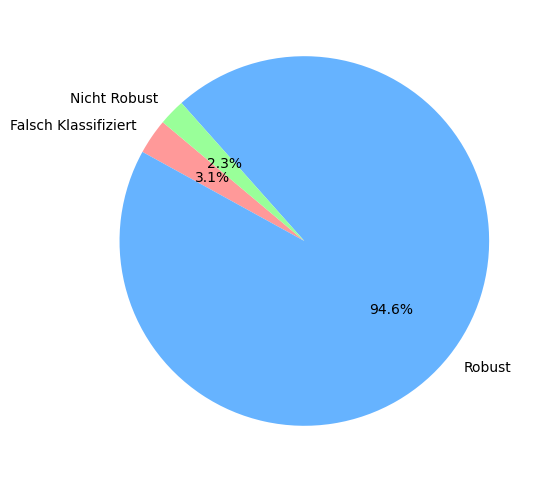

C:\Users\arthu\AppData\Local\Temp\ipykernel_26036\3824252981.py:131: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


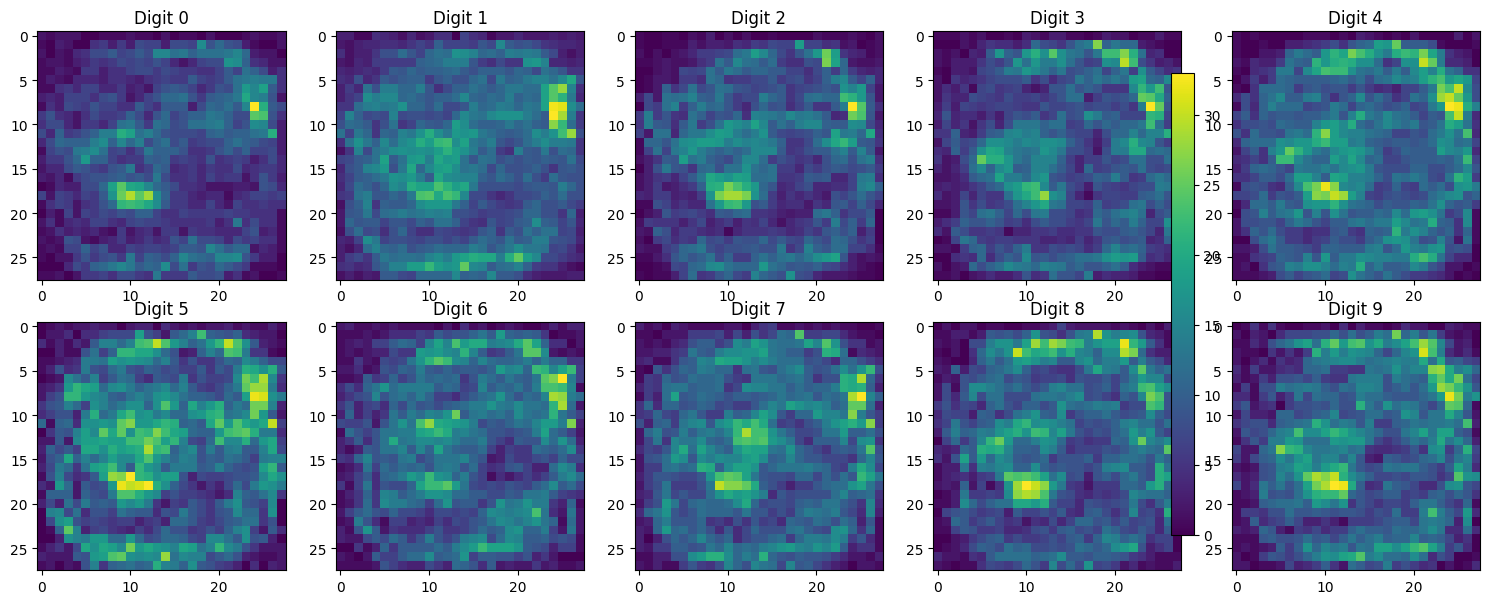

In [34]:
plot_overall_robustness(stats.incorrect, stats.robust, stats.not_robust)
plot_error_heatmaps(stats.error_sums)